# Ensemble Methods w/ Feature Integration

1. Feature Integration
    - 상관관계 분석을 통해 중요한 이상치 탐지에 영향을 많이 주는 feature를 선별한다.
    (is done in FeatureIntegration.ipynb)
2. Elliptic Envelope
    - train datset에 적합 후 test dataset에 대한 사기거래 여부를 판별한다. (for ensemble)
    - train datset의 해당 feature에 label값(정상, 사기)을 부여한다. (for classifying)
3. LGBM, XGboost
    - label값이 주어졌다면 비지도학습이 아닌 지도학습의 문제로 변한다.
    - 지도학습에서 사용할 수 있는 분류 모델들을 적용해 본다.
4. 분류모델과 Elliptic Envelope을 통해 얻은 사기거래 여부를 ensemble.

### LGBM vs XGBoost
1. 학습 속도와 효율성:    
   LGBM은 빠른 학습 속도와 효율적인 메모리 사용으로 알려져 있다.  
   이는 histogram 기반 알고리즘과 leaf-wise 트리 성장 전략을 통해 달성된다.     
   반면 XGBoost도 효율적이지만, 일반적으로 LGBM은 훨씬 빠른 학습 시간을 제공하며, 특히 대규모 데이터셋에서 유리하다.  

2. 트리 성장 전략: 
   LGBM은 leaf-wise 트리 성장 전략을 사용한다.  
   트리를 손실을 가장 많이 개선하는 말단 노드를 추가하여 성장시킨다.  
   이로 인해 빠른 수렴과 더 효율적인 트리 구조를 얻을 수 있다.  
   XGBoost는 다른 접근 방식인 level-wise 트리 성장 전략을 사용한다.  
   이 전략은 트리를 레벨별로 구성하며, 균형 잡힌 트리 구조를 유지하지만 속도 면에서는 덜 효율적일 수 있다.

3. 범주형 feature 처리:  
   LGBM은 명시적인 인코딩 없이 범주형 피처를 처리할 수 있는 기능을 내장하고 있다.  
   범주형 변수를 직접 사용할 수 있어 전처리 단계를 간소화할 수 있다.  
   반면 XGBoost는 범주형 피처를 원-핫 인코딩이나 서수 인코딩과 같은 숫자 표현으로 변환해야 힌다. 

In [24]:
import numpy as np 
import pandas as pd
import math

from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.covariance import EllipticEnvelope
from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import lightgbm 
from lightgbm import LGBMClassifier
import optuna
from optuna.samplers import TPESampler

import torch

In [25]:
# from FeatureIntegration.ipynb
USE_FEATURE = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']

In [26]:
train = pd.read_csv('data/train.csv')
val = pd.read_csv('data/val.csv')
test = pd.read_csv('data/test.csv')

In [27]:
train.drop('ID', axis=1, inplace=True)
val.drop('ID', axis=1, inplace=True)
test.drop('ID', axis=1, inplace=True)

In [28]:
train_df = train[USE_FEATURE]
val_df = val[USE_FEATURE+['Class']]
test_df = test[USE_FEATURE]

In [29]:
display(train.head(), val.head(), test.head())

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0
1,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,0.724396,...,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0
2,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,0.757952,...,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0
3,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,-0.225495,...,0.079359,0.096632,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0
4,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,6.051521,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,-0.994983
2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,-0.994960
3,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.237686,-0.994937
4,0.384978,0.616109,-0.874300,-0.094019,2.924584,3.317027,0.470455,0.538247,-0.558895,0.309755,...,0.049924,0.238422,0.009130,0.996710,-0.767315,-0.492208,0.042472,-0.054337,-0.167819,-0.994866


In [30]:
display(train_df.head(), val_df.head(), test_df.head())

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18
0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359
1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775
2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,-0.568671,-0.371407,1.341262,0.359894,-0.137134,0.401726,-0.058133,0.068653
3,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,0.615375,1.249376,-0.619468,0.291474,-1.323865,-0.076127,-1.222127,-0.358222
4,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,-0.392048,-0.410430,-0.705117,-0.110452,0.074355,-0.210077,-0.499768,0.118765


,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,Class
0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,-0.736727,-0.366846,1.017614,0.836390,-0.443523,0.739453,-0.540980,0.476677,0
1,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,-1.191311,0.724396,1.690330,0.406774,0.983739,-0.602232,0.402484,-1.737162,0
2,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.896287,0.757952,-0.448937,-0.660863,0.788864,0.295404,-0.287878,-0.451453,0
3,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.226278,-0.225495,1.944545,1.385160,0.314166,-1.333716,1.002869,-2.119314,0
4,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,4.009259,6.051521,2.572500,0.066851,-2.837136,-0.303774,-1.942303,-0.435450,0


,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361
2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195
3,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.464960,-0.099254,-1.416907,-0.153826,0.167372,-0.443587,0.002821,-0.611987
4,0.384978,0.616109,-0.874300,-0.094019,2.924584,3.317027,0.470455,-0.558895,0.309755,-0.259116,-0.326143,0.362832,-0.129487,-0.809979,0.359985


# Elliptic Envelope
    - Elliptic Envelope은 Valdation 데이터셋에서의 사기거래 비율이 다른 데이터셋에서도 비슷하게 나타난다는 가정이 필요하다. 

In [31]:
# Validation Dataset Fraud count/ratio
fraud_count = val_df['Class'].value_counts()[1]
fraud_ratio = fraud_count/len(val_df)
print(f'사기거래 개수: {fraud_count}, 사기거래 비율: {fraud_ratio}')

사기거래 개수: 30, 사기거래 비율: 0.0010540369615627855


In [32]:
def pred_Ellip_Env(model, x, k):
    prob = model.score_samples(x)
    prob = torch.tensor(prob, dtype=torch.float)
    top_k = torch.topk(prob, k=k, largest=False).indices
    
    pred = np.zeros(len(x), dtype=np.int32)
    pred[top_k] = 1
    
    return np.array(pred)

- support_fraction값에 대해 tuning

In [33]:
support_fraction = np.arange(0.99, 0.999, 0.001).round(3) # candidates
score = list()
for sf in support_fraction:
    model = EllipticEnvelope(support_fraction=sf, contamination=fraud_ratio, random_state=302)
    model.fit(train_df)
    pred = pred_Ellip_Env(model, val_df.drop('Class', axis=1), fraud_count)
    sc = f1_score(pred, val_df['Class'])
    print(f'Support Fraction: {sf}, F1 Score: {sc}')
    score.append(sc)

Support Fraction: 0.99, F1 Score: 0.8000000000000002
Support Fraction: 0.991, F1 Score: 0.8000000000000002
Support Fraction: 0.992, F1 Score: 0.8000000000000002
Support Fraction: 0.993, F1 Score: 0.8333333333333334
Support Fraction: 0.994, F1 Score: 0.8333333333333334
Support Fraction: 0.995, F1 Score: 0.8333333333333334
Support Fraction: 0.996, F1 Score: 0.8333333333333334
Support Fraction: 0.997, F1 Score: 0.8333333333333334
Support Fraction: 0.998, F1 Score: 0.8333333333333334
Support Fraction: 0.999, F1 Score: 0.8333333333333334


In [34]:
model = EllipticEnvelope(support_fraction=0.994, contamination=fraud_ratio, random_state=302)
model.fit(train_df)
ellip_pred = pred_Ellip_Env(model, test_df, 313)

# LGBM

- classifier 적용을 위해 elliptic envelope을 이용하여 train dataset에 label을 부여한다.

In [35]:
import math
train_fraud_count = math.ceil(len(train)*fraud_ratio)
print(f'train dataset 추정 사기거래 개수: {train_fraud_count}')

train dataset 추정 사기거래 개수: 120


In [36]:
# Elliptic Envelope을 이용한 train dataset 정상/사기 label
train_label = pred_Ellip_Env(model, train_df, train_fraud_count)

Optuna Module을 이용, LGBM모델에 대하여 hyperparameter tuning

In [37]:
score = []
def optmization(trial):
    score = []
    skf = StratifiedKFold(n_splits=5, random_state=302, shuffle=True)
    for train_fold, test_fold in tqdm(skf.split(train_df, train_label), desc='k_fold'):
        X_train, X_test, y_train, y_test = train_df.iloc[train_fold], train_df.iloc[test_fold], train_label[train_fold], train_label[test_fold] 
        
        # parameters candidates
        params = {            
            "boosting_type" : trial.suggest_categorical('boosting_type',['dart','gbdt']),
            "learning_rate": trial.suggest_float('learning_rate', 0.2, 0.99),
            "n_estimators": trial.suggest_int("n_estimators", 100, 300, step=10),
            "max_depth": trial.suggest_int("max_depth", 1, 15),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 1),
            "subsample": trial.suggest_float("subsample", 0.4, 1.0),
            "subsample_freq": trial.suggest_int("subsample_freq", 1, 30),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
            "max_bin": trial.suggest_int("max_bin", 50, 100),
            "verbosity": -1,
            "random_state": trial.suggest_int("random_state", 1, 302)
        }
        lgb = LGBMClassifier(**params)
        lgb.fit(X_train, y_train)
        lgb_cv_pred = lgb.predict(X_test)
        
        score_cv = f1_score(train_label[test_fold] , lgb_cv_pred , average = 'macro')
        
        score.append(score_cv)
    # print(score)
    return np.mean(score) 

In [ ]:
sampler = TPESampler()
optim = optuna.create_study(direction="maximize", sampler=sampler)
optim.optimize(optmization, n_trials=300)

In [39]:
print(optim.best_value)

0.9656079608968515


In [40]:
params = optim.best_params
# {'boosting_type': 'dart', 'learning_rate': 0.6289108273807875, 'n_estimators': 130, 
#           'max_depth': 8, 'num_leaves': 116, 'reg_alpha': 0.40500310432076914, 
#           'reg_lambda': 0.8957307029764465, 'subsample': 0.9065827055314348, 'subsample_freq': 21, 
#           'colsample_bytree': 0.8763459446821508, 'min_child_samples': 43, 'max_bin': 82, 'random_state': 85}

In [41]:
model = LGBMClassifier(**params)
model.fit(train_df, train_label)
lgbm_pred = model.predict(val_df.drop('Class', axis=1))

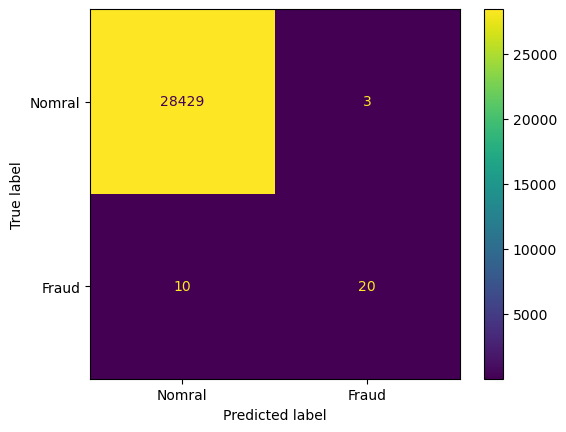

In [42]:
val_label = val_df['Class']
cm = confusion_matrix(val_label, lgbm_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Nomral', 'Fraud'])
disp.plot()

In [44]:
lgbm_pred_test = model.predict(test_df)

In [47]:
submit = pd.read_csv('data/sample_submission.csv')
submit['Class'] = ellip_pred | lgbm_pred_test
submit.to_csv('submit/submit_Ensemble_LGBM_EllipticEnvelope_FI.csv', index=False)